#*Imports*#

In [1]:
## Conection with Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input,Average

#*Directory Data Flow*#

In [3]:
# Define the directories for the training, validation, and testing data:
train_dir = '/content/drive/MyDrive/project_phase_2/Leaf_Disease_Aug/train/'
val_dir = '/content/drive/MyDrive/project_phase_2/Leaf_Disease_Aug/val/'
test_dir = '/content/drive/MyDrive/project_phase_2/Leaf_Disease_Aug/test/'

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data generators for the training, validation, and testing data:
batch_size = 128
img_dims = 224

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224),
                                                    batch_size=batch_size, class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(224, 224),
                                                batch_size=batch_size, class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224),
                                                  batch_size=batch_size, class_mode='categorical')

Found 7622 images belonging to 4 classes.
Found 951 images belonging to 4 classes.
Found 949 images belonging to 4 classes.


##*Data X, y*##

In [5]:
input_test = test_dir
labels = os.listdir(input_test)
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_dims, img_dims)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [6]:
test_set_ = get_data(input_test)

## X and y test
X_test, y_test = [],[]
for feature, labels in test_set_:
  X_test.append(feature)
  y_test.append(labels)
## Convert the data in arrays 
X_test = np.array(X_test) / 255
y_test = np.array(y_test)

<ipython-input-5-e3d239c42c2b>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


#*Models*#

In [7]:
from sklearn.metrics import accuracy_score
model_1 = load_model('/content/drive/MyDrive/project_phase_2/models/vgg_best_model.h5')
model_2 = load_model('/content/drive/MyDrive/project_phase_2/models/mobilenet_best_model.h5')
model_3 = load_model('/content/drive/MyDrive/project_phase_2/models/inception_best_model.h5')
model_4 = load_model('/content/drive/MyDrive/project_phase_2/models/xception_best_model.h5')

models = [model_1,model_2, model_3, model_4]

#*Ensemble Approaches*#

In [8]:
preds = [model.predict(X_test) for model in models]
preds=np.array(preds)

30/30 [==============================] - 238s 8s/step


In [ ]:
prediction1 = np.argmax(preds[0], axis = 1)
prediction2 = np.argmax(preds[1], axis = 1)
prediction3 = np.argmax(preds[2], axis = 1)
prediction4 = np.argmax(preds[3], axis = 1)

accuracy1 = accuracy_score(y_test, prediction1)
accuracy2 = accuracy_score(y_test, prediction2)
accuracy3 = accuracy_score(y_test, prediction3)
accuracy4 = accuracy_score(y_test, prediction4)

print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)
print('Accuracy Score for model4 = ', accuracy4)

Accuracy Score for model1 =  0.9412306638566913
Accuracy Score for model2 =  0.9331190727081138
Accuracy Score for model3 =  0.9197871443624869
Accuracy Score for model4 =  0.9324531085353003


#*Majority Voting*#

In [ ]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

voting_prediction = np.zeros(shape=len(prediction1))

# Loop through the arrays and find the most common value for each index
for i in range(len(prediction1)):
    values = [prediction1[i], prediction2[i], prediction3[i], prediction4[i]]
    voting_prediction[i] = int(max(set(values), key=values.count))

voting_accuracy = accuracy_score(y_test, voting_prediction)
print('Accuracy Score for majority voting ensemble = ', voting_accuracy)

Accuracy Score for majority voting ensemble =  0.9546891464699684


                precision    recall  f1-score   support

        Blight       0.91      0.90      0.91       228
   Common_Rust       1.00      1.00      1.00       239
Gray_Leaf_Spot       0.91      0.92      0.91       239
       Healthy       1.00      1.00      1.00       243

      accuracy                           0.95       949
     macro avg       0.95      0.95      0.95       949
  weighted avg       0.95      0.95      0.95       949



[Text(0, 0, 'Blight'),
 Text(0, 1, 'Common_Rust'),
 Text(0, 2, 'Gray_Leaf_Spot'),
 Text(0, 3, 'Healthy')]

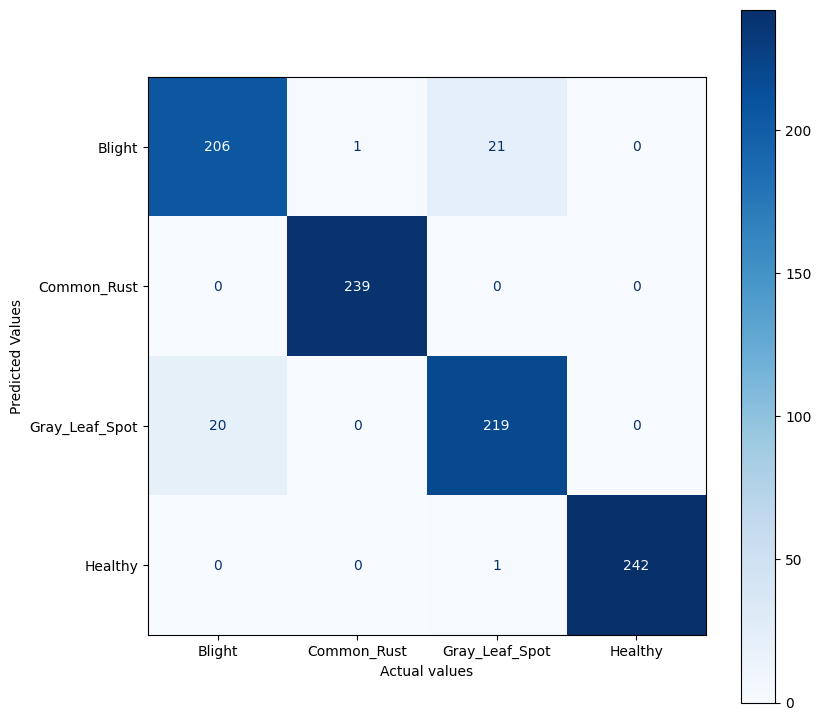

In [ ]:
class_names = ["Blight", "Common_Rust","Gray_Leaf_Spot", "Healthy"]
print(classification_report(y_test,voting_prediction, target_names = class_names))

fig, ax = plt.subplots(figsize=(9,9))
ConfusionMatrixDisplay.from_predictions(y_test, voting_prediction, cmap = 'Blues', ax = ax)
ax.set_xlabel("Actual values")
ax.set_ylabel("Predicted Values")
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

#*Average Approach*#

In [ ]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

summed = np.sum(preds, axis=0)
# argmax across classes
ensemble_prediction = np.argmax(summed, axis=1)

ensemble_accuracy = accuracy_score(y_test, ensemble_prediction)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)

Accuracy Score for average ensemble =  0.9652265542676501


                precision    recall  f1-score   support

        Blight       0.97      0.88      0.92       228
   Common_Rust       1.00      1.00      1.00       239
Gray_Leaf_Spot       0.90      0.97      0.94       239
       Healthy       1.00      1.00      1.00       243

      accuracy                           0.97       949
     macro avg       0.97      0.96      0.96       949
  weighted avg       0.97      0.97      0.97       949



[Text(0, 0, 'Blight'),
 Text(0, 1, 'Common_Rust'),
 Text(0, 2, 'Gray_Leaf_Spot'),
 Text(0, 3, 'Healthy')]

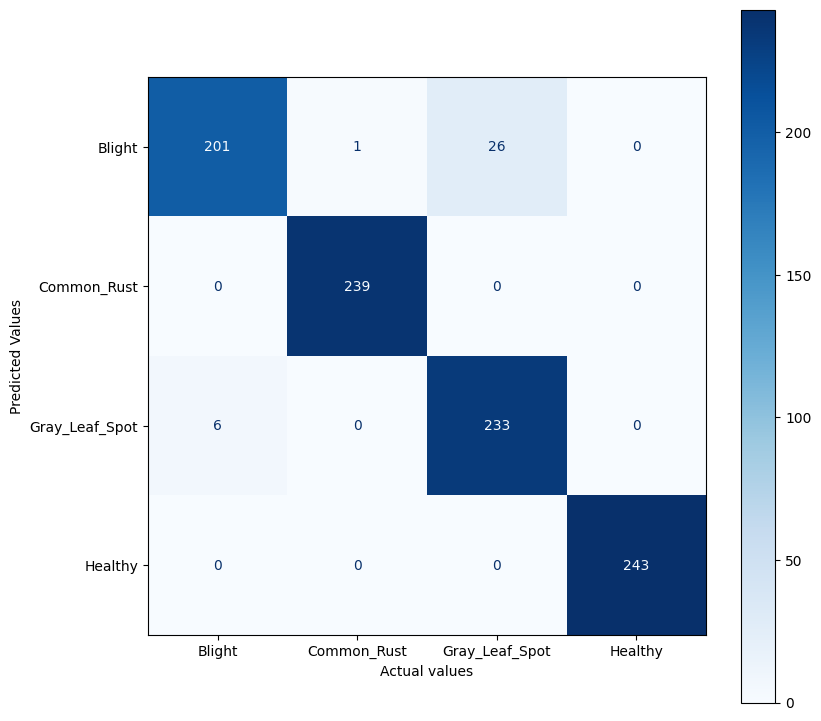

In [ ]:
class_names = ["Blight", "Common_Rust","Gray_Leaf_Spot", "Healthy"]
print(classification_report(y_test,ensemble_prediction, target_names = class_names))

fig, ax = plt.subplots(figsize=(9,9))
ConfusionMatrixDisplay.from_predictions(y_test, ensemble_prediction, cmap = 'Blues', ax = ax)
ax.set_xlabel("Actual values")
ax.set_ylabel("Predicted Values")
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

#*Weighted Average Approach*#

In [ ]:
weights = [0.2, 0.4, 0.1, 0.3]
#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(y_test, weighted_ensemble_prediction)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)

Accuracy Score for weighted average ensemble =  0.9673340358271865


                precision    recall  f1-score   support

        Blight       0.96      0.90      0.93       228
   Common_Rust       1.00      1.00      1.00       239
Gray_Leaf_Spot       0.91      0.97      0.94       239
       Healthy       1.00      1.00      1.00       243

      accuracy                           0.97       949
     macro avg       0.97      0.97      0.97       949
  weighted avg       0.97      0.97      0.97       949



[Text(0, 0, 'Blight'),
 Text(0, 1, 'Common_Rust'),
 Text(0, 2, 'Gray_Leaf_Spot'),
 Text(0, 3, 'Healthy')]

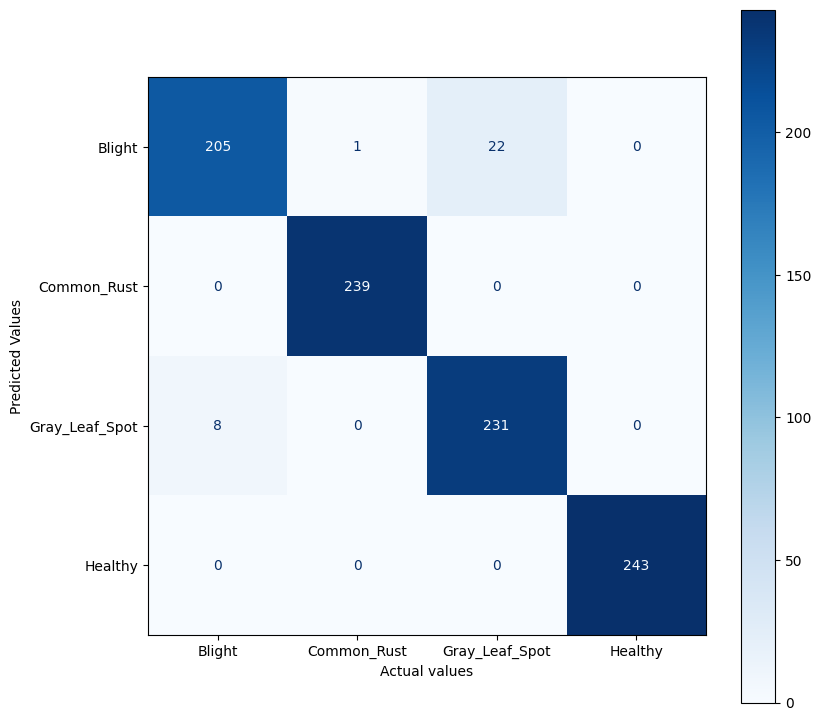

In [ ]:
class_names = ["Blight", "Common_Rust","Gray_Leaf_Spot", "Healthy"]
print(classification_report(y_test,weighted_ensemble_prediction, target_names = class_names))

fig, ax = plt.subplots(figsize=(9,9))
ConfusionMatrixDisplay.from_predictions(y_test, weighted_ensemble_prediction, cmap = 'Blues', ax = ax)
ax.set_xlabel("Actual values")
ax.set_ylabel("Predicted Values")
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

#*Grid search for the best combination of weights*#

In [ ]:
wei1,wei2,wei3,wei4=0,0,0,0
best_wei_acc=0

for w1 in range(0,6):
    for w2 in range(0,6):
        for w3 in range(0,6):
          for w4 in range(0,6):
            wts = [w1/10.,w2/10.,w3/10.,w4/10.]
            wted_preds = np.tensordot(preds, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds, axis=1)
            weighted_accuracy = accuracy_score(y_test, wted_ensemble_pred)*100
            if weighted_accuracy>=best_wei_acc:
              best_wei_acc = weighted_accuracy
              wei1,wei2,wei3,wei4=wts[0],wts[1],wts[2],wts[3]
            
print("Max accuracy of ", best_wei_acc, " obained with w1=", wei1,
      " w2=", wei2, " w3=", wei3, " and w4=", wei4)         

Max accuracy of  97.68177028451001  obained with w1= 0.4  w2= 0.3  w3= 0.4  and w4= 0.1


                precision    recall  f1-score   support

        Blight       0.98      0.92      0.95       228
   Common_Rust       1.00      1.00      1.00       239
Gray_Leaf_Spot       0.93      0.98      0.96       239
       Healthy       1.00      1.00      1.00       243

      accuracy                           0.98       949
     macro avg       0.98      0.98      0.98       949
  weighted avg       0.98      0.98      0.98       949



[Text(0, 0, 'Blight'),
 Text(0, 1, 'Common_Rust'),
 Text(0, 2, 'Gray_Leaf_Spot'),
 Text(0, 3, 'Healthy')]

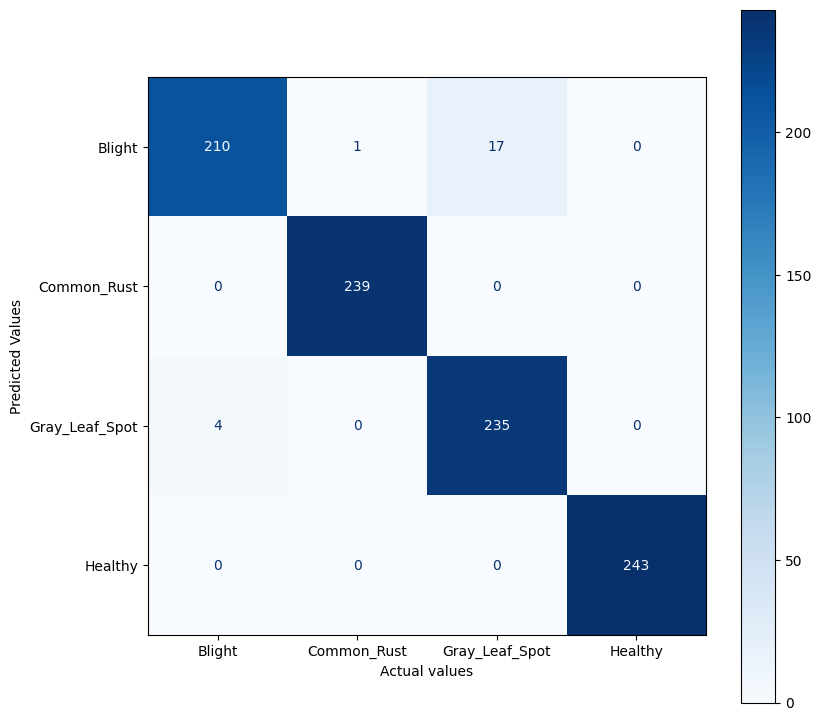

In [ ]:
best_weights = [0.4, 0.3, 0.4, 0.1]
#Use tensordot to sum the products of all elements over specified axes.
best_weighted_preds = np.tensordot(preds, best_weights, axes=((0),(0)))
best_weighted_ensemble_prediction = np.argmax(best_weighted_preds, axis=1)

best_weighted_accuracy = accuracy_score(y_test, best_weighted_ensemble_prediction)

class_names = ["Blight", "Common_Rust","Gray_Leaf_Spot", "Healthy"]
print(classification_report(y_test,best_weighted_ensemble_prediction, target_names = class_names))

fig, ax = plt.subplots(figsize=(9,9))
ConfusionMatrixDisplay.from_predictions(y_test, best_weighted_ensemble_prediction, cmap = 'Blues', ax = ax)
ax.set_xlabel("Actual values")
ax.set_ylabel("Predicted Values")
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

#*Test Best Model*#

In [16]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

weights = [0.4, 0.3, 0.4, 0.1]
#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

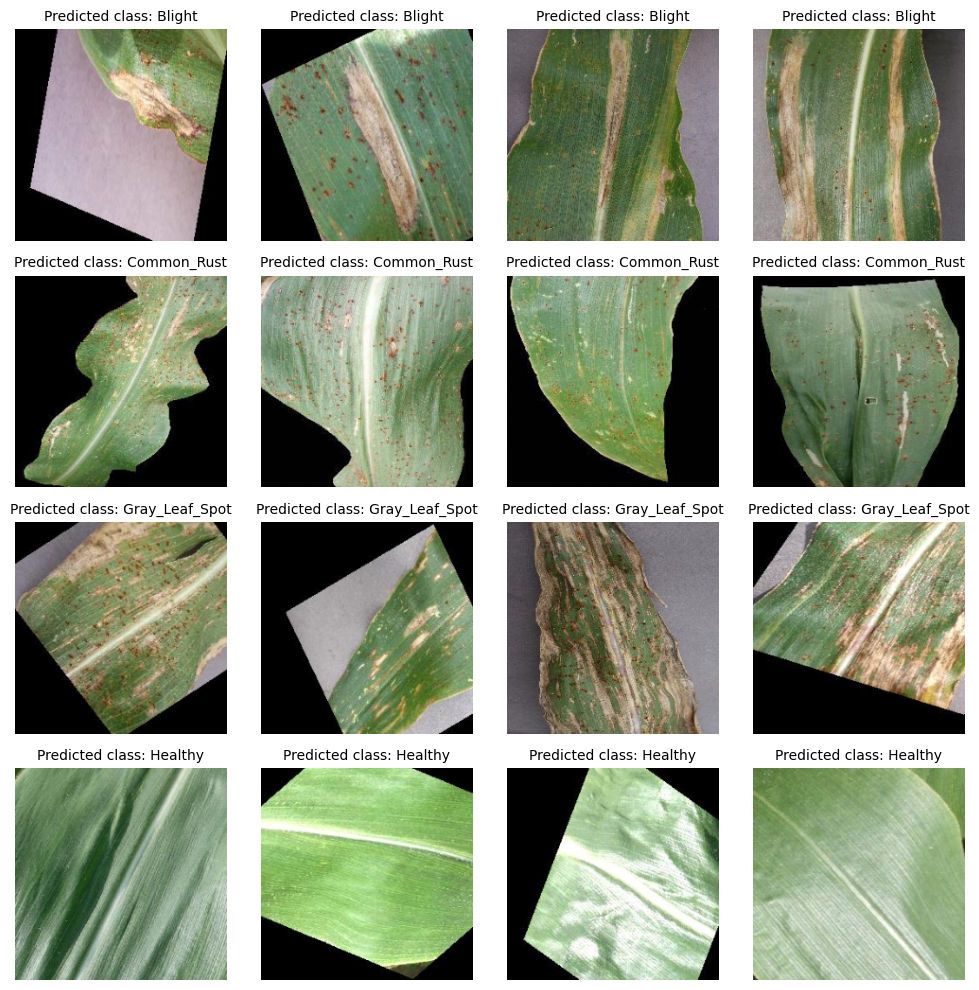

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Specify the indices of the images you want to plot
image_indices = [0,7,18,100,232,312,405,455,29,500,604,641,709,805,859,908]  # Example: 3rd and 100th image

# Get the selected images from X_test
images = X_test[image_indices]

# Create the subplot grid
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Flatten the axes array to simplify indexing
axes = axes.flatten()

classes = ["Blight", "Common_Rust","Gray_Leaf_Spot", "Healthy"]
# Iterate over the images and plot them
for i in range(16):
    class_idx = weighted_ensemble_prediction[image_indices[i]]
    predicted_class = classes[class_idx]
    axes[i].imshow(images[i], cmap='gray')
    axes[i].set_title(f'Predicted class: {predicted_class}',fontsize=10)
    axes[i].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()
